In [2]:
import geopandas as gpd
import pandas as pd 
import requests
import matplotlib.pyplot as plt 
import zipfile
import io
import json
from shapely.geometry import Point
import contextily as cx
import openrouteservice
from io import StringIO 

In [3]:
# getting school zones data 

url = 'https://www.education.vic.gov.au/Documents/about/research/datavic/dv371_DataVic_School_Zones_2024.zip' 
response = requests.get(url)
full_path = '/Users/rchrdha/Documents/GitHub/project-2-group-real-estate-industry-project-34/data/raw/Secondary_Integrated_Year12_2024.geojson'

if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        geojson_filename = 'Secondary_Integrated_Year12_2024.geojson'  
        
        with zip_file.open(geojson_filename) as geojson_file:
            gdf = gpd.read_file(geojson_file)
        gdf.to_file(full_path, driver="GeoJSON")
        
gdf

,School_Name,Campus_Name,ENTITY_CODE,Year_Level,Boundary_Year,geometry
0,Pakenham Secondary College,Pakenham Secondary College,1822301,12,2024,"POLYGON ((145.65940 -38.11167, 145.70007 -37.9..."
1,Koo Wee Rup Secondary College,Koo Wee Rup Secondary College,1795501,12,2024,"POLYGON ((145.44638 -38.13750, 145.39423 -38.1..."
2,Phoenix P-12 Community College,Sebastopol Campus,1890001,12,2024,"POLYGON ((143.86837 -37.58028, 143.85475 -37.5..."
3,Mount Clear College,Mount Clear College,1726701,12,2024,"POLYGON ((143.63256 -37.88079, 143.69426 -37.9..."
4,Ballarat High School,Ballarat High School,1754001,12,2024,"POLYGON ((143.85475 -37.56184, 143.85634 -37.5..."
...,...,...,...,...,...,...
279,Edgars Creek Secondary College,Edgars Creek Secondary College,1708101,12,2024,"POLYGON ((145.00677 -37.51908, 144.97096 -37.5..."
280,Richmond High School,Richmond High School,1827102,12,2024,"POLYGON ((145.02615 -37.79446, 145.03688 -37.8..."
281,Beaumaris Secondary College,Beaumaris Secondary College,1756601,12,2024,"POLYGON ((145.05775 -37.96564, 145.04401 -37.9..."
282,Preston High School,Preston High School,1824101,12,2024,"POLYGON ((144.99353 -37.71975, 144.99055 -37.7..."


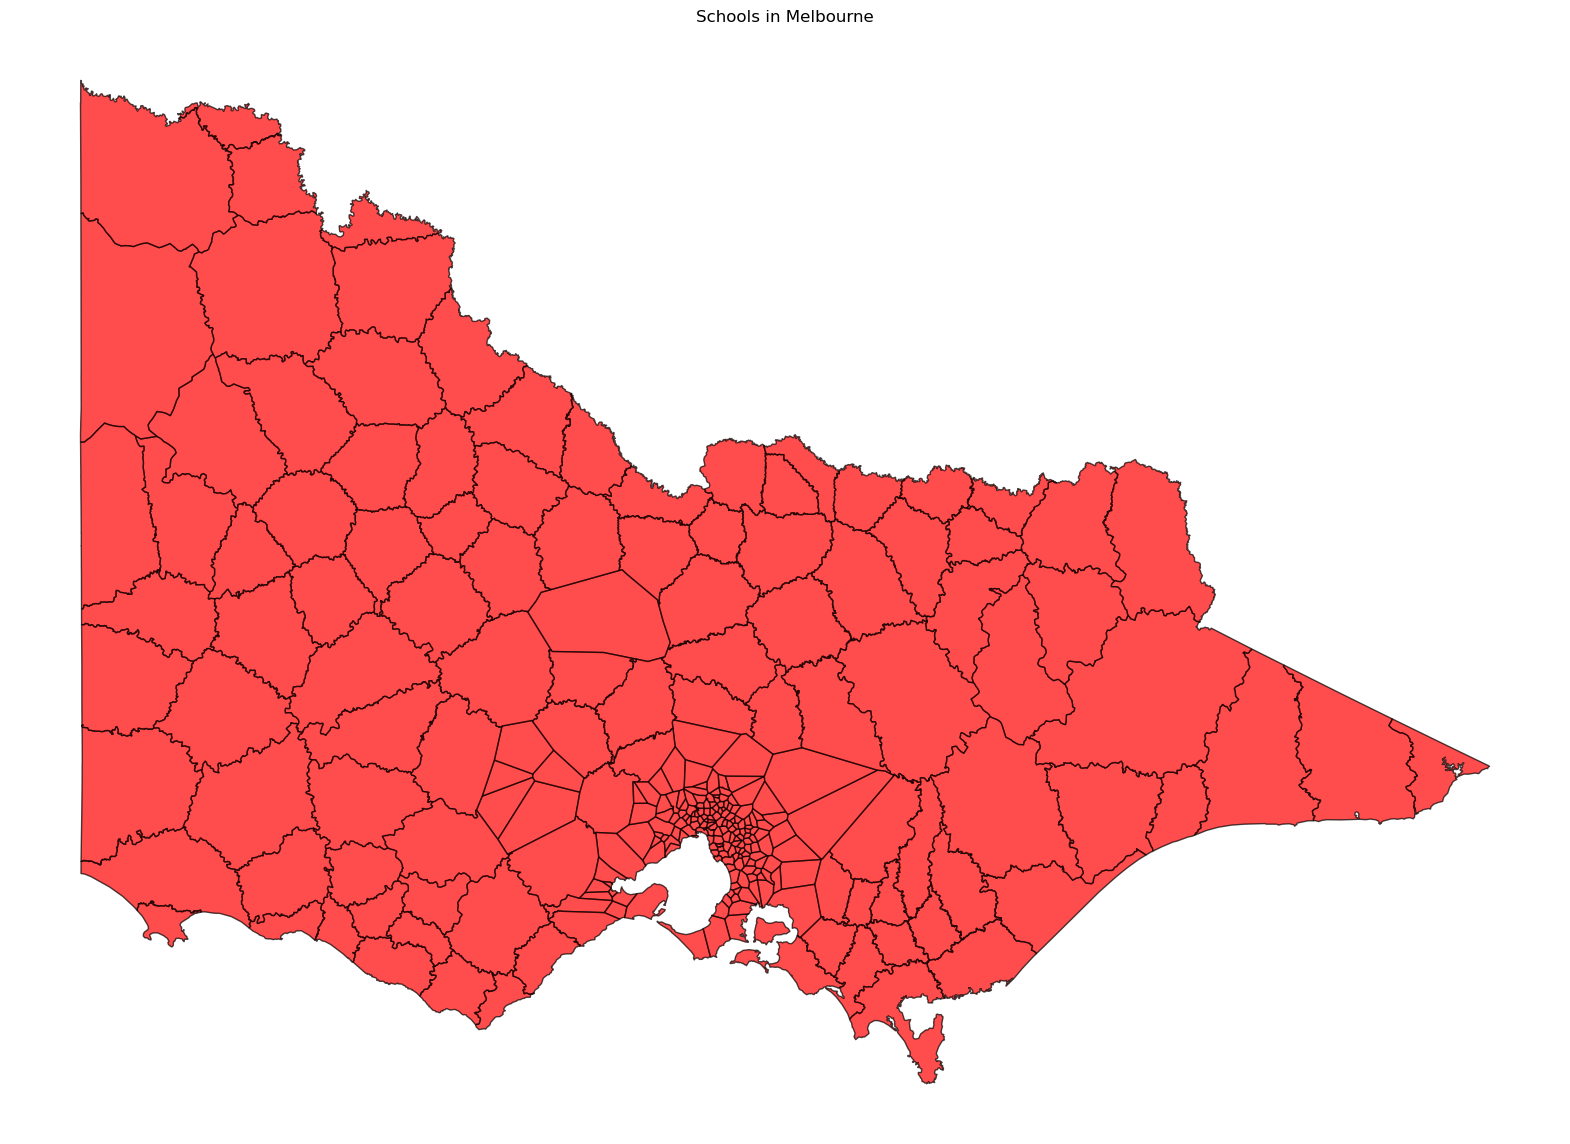

In [3]:
# No private schools / selective schools because they do not apply under the catchment zone system 
# want to visualise the school data on the Melbourne Map 

fig1, ax1 = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax1, markersize=5, color='red', edgecolor='black', alpha=0.7)
plt.title("Schools in Melbourne")
ax1.set_axis_off()
plt.show()


/var/folders/4r/krw46gbs0qb49j9lv1ybjb6w0000gn/T/ipykernel_34307/686455249.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


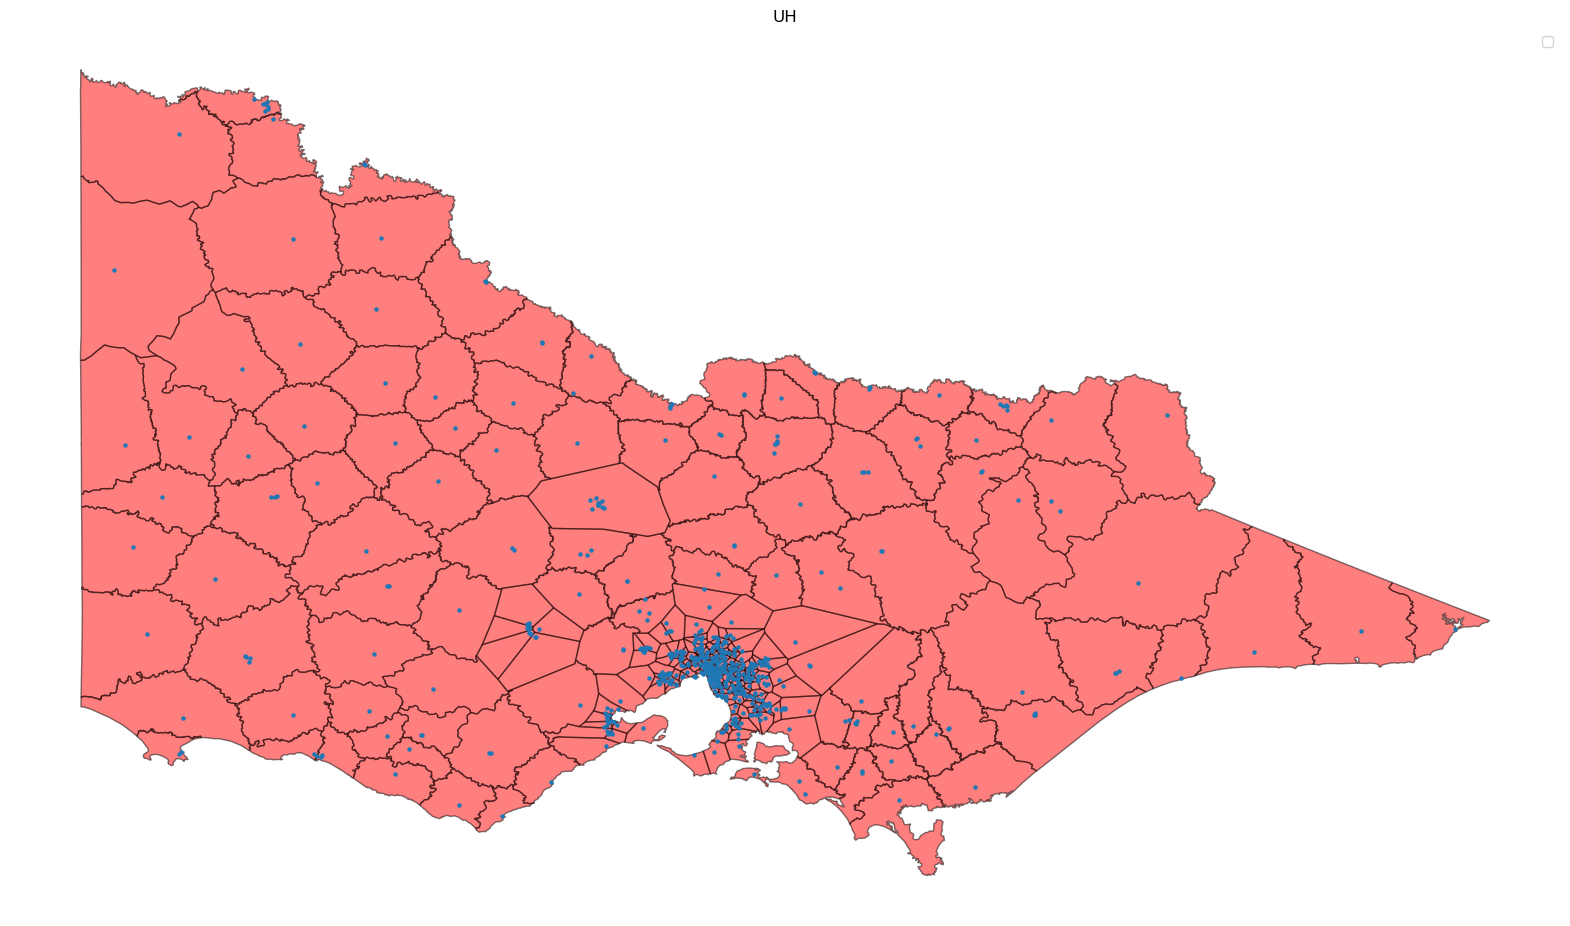

In [4]:
# Downloading specific school locations 

url = 'https://www.education.vic.gov.au/Documents/about/research/datavic/dv346-schoollocations2023.csv'
response = requests.get(url)
full_path = '/Users/rchrdha/Documents/GitHub/project-2-group-real-estate-industry-project-34/data/raw/VIC_SCHOOL_LOCATIONS.geojson'

csv_content = response.content.decode('ISO-8859-1')

schools_df = pd.read_csv(StringIO(csv_content))

# school_names = gdf['School_Name'].tolist()
# filtered_school_locations =schools_df[schools_df['School_Name'].isin(school_names)]
# print(filtered_school_locations)

# cleaning school dataset, removing irrelevant columns and splitting into government schools and private schools 
schools_df = schools_df[schools_df['School_Type'].isin(['Pri/Sec', 'Secondary'])].reset_index(drop=True)
cols_to_drop = ['Entity_Type','School_No','School_Type', 'School_Status', 'Address_Line_2', 'Address_State','Postal_Address_Line_1','Postal_Address_Line_2','Postal_Town','Postal_State','Postal_Postcode','Full_Phone_No','LGA_ID', 'LGA_Name']
schools_df = schools_df.drop(cols_to_drop, axis='columns')

schools_df['geometry'] = schools_df.apply(lambda row: Point(row['X'], row['Y']), axis=1)
schools_gdf = gpd.GeoDataFrame(schools_df, geometry='geometry')
schools_gdf.set_crs(epsg=3857, inplace=True)

govschools_gdf = schools_gdf[schools_df['Education_Sector'] == 'Government'].reset_index(drop=True)
govschools_gdf.to_csv('/Users/rchrdha/Documents/GitHub/project-2-group-real-estate-industry-project-34/data/curated/govschools_gdf.csv', index=False)
privschools_gdf = schools_gdf[schools_df['Education_Sector'] != 'Government'].reset_index(drop=True)
privschools_gdf.to_csv('/Users/rchrdha/Documents/GitHub/project-2-group-real-estate-industry-project-34/data/curated/privschools_gdf.csv',index=False)


fig1, ax1 = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax1, color='red', edgecolor='black',alpha=0.5, label='School Zones')
schools_gdf.plot(ax=ax1, markersize=5)
ax1.set_title('UH')
ax1.legend()
plt.axis('off')
plt.show()


In [5]:
# reading in the preprocessed data from Rob and converting to Pandas

listings_df =pd.read_parquet('/Users/rchrdha/Documents/GitHub/project-2-group-real-estate-industry-project-34/data/curated/preprocessed_rent_data.parquet', engine='pyarrow')

listings_gdf = gpd.GeoDataFrame(
    listings_df,
    geometry = gpd.points_from_xy(listings_df.longitude, listings_df.latitude),
    crs='EPSG:3857'
)
listings_gdf 
#client= openrouteservice.Client(key='5b3ce3597851110001cf6248afd1cab1431b4151b537945f4e0db634')

def nearest_school(listing, schools_gdf):
    distances = schools_gdf.geometry.distance(listing)
    nearest_index = distances.idxmin()
    return schools_gdf.loc[nearest_index]

nearest_schools = listings_gdf['geometry'].apply(lambda listing: nearest_school(listing, schools_gdf))





In [6]:


listings_gdf = listings_gdf.join(nearest_schools.reset_index(drop=True), rsuffix='_nearest')


address               196908
state                 196908
suburb                196908
bedrooms              196908
bathrooms             196908
propertyTypes         196898
carspaces             196908
date_listed           196908
latitude              196908
longitude             196908
is_new_development    196908
price                 196908
propertyId            131200
is_furnished          196908
year                  196908
month                 196908
day                   196908
SA2_CODE21            196744
geometry              196908
Education_Sector      196908
School_Name           196908
Address_Line_1        196908
Address_Town          196908
Address_Postcode      196908
X                     196908
Y                     196908
geometry_nearest      196908
dtype: int64

In [8]:
# getting the distance between each listing to the nearest school 

def calc_distance(row):
    listing_geom = row['geometry']
    nearest_school_geom = row['geometry_nearest']

    distance = listing_geom.distance(nearest_school_geom)

    return distance 


listings_gdf['dist_to_near_school'] = listings_gdf.apply(calc_distance, axis=1 )

listings_gdf.to_csv("/Users/rchrdha/Documents/GitHub/project-2-group-real-estate-industry-project-34/data/curated/listing_with_school.csv",index=False)


In [9]:
# calculating the distance in another way using geodesic to check logic 

from geopy.distance import geodesic

def calc_distance_geodesic(row):
    listing_geom = row['geometry']
    nearest_school_geom = row['geometry_nearest']

    distance = geodesic(listing_geom, nearest_school_geom).meters
    return distance 


listings_gdf['dist_to_near_school_geodesic'] = listings_gdf.apply(calc_distance, axis=1 )

listings_gdf

,address,state,suburb,bedrooms,bathrooms,propertyTypes,carspaces,date_listed,latitude,longitude,...,Education_Sector,School_Name,Address_Line_1,Address_Town,Address_Postcode,X,Y,geometry_nearest,dist_to_near_school,dist_to_near_school_geodesic
0,"1201/55 Queens Road, Melbourne VIC 3000",vic,Melbourne,2.0,2.0,[apartmentUnitFlat],2.0,2009-05-08,-37.847967,144.977640,...,Independent,Wesley College,577 St Kilda Road,MELBOURNE,3004,144.98214,-37.84883,POINT (144.98214 -37.84883),0.004582,0.004582
1,"211/G04K Powlett Street, East Melbourne VIC 3002",vic,East Melbourne,3.0,2.0,[apartmentUnitFlat],1.0,2009-05-08,-37.812575,144.985854,...,Government,Collingwood College,Cnr Cromwell St/McCutcheon Way,Collingwood,3066,144.99050,-37.80298,POINT (144.9905 -37.80298),0.010661,0.010661
2,Rye VIC 3941,vic,Rye,3.0,2.0,[house],4.0,2009-05-08,-38.373284,144.817655,...,Government,Rosebud Secondary College,245 Eastbourne Road,Rosebud,3939,144.88745,-38.36762,POINT (144.88745 -38.36762),0.070024,0.070024
3,"1204/454 St Kilda Road, Melbourne St Kilda Roa...",vic,Melbourne St Kilda Road,3.0,3.0,[apartmentUnitFlat],2.0,2009-05-11,-37.839405,144.976224,...,Government,MacRobertson Girls High School,350-370 Kings Way,Melbourne,3004,144.97186,-37.83589,POINT (144.97186 -37.83589),0.005604,0.005604
4,"211 Wellington Pde Sth, East Melbourne VIC 3002",vic,East Melbourne,3.0,3.0,[apartmentUnitFlat],2.0,2009-05-11,-37.816637,144.977522,...,Independent,Holmes Grammar School,185 Spring Street,MELBOURNE,3000,144.97227,-37.81030,POINT (144.97227 -37.8103),0.008230,0.008230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147642,"3306/80 Abeckett Street, Melbourne VIC 3000",vic,Melbourne,2.0,1.0,[apartmentUnitFlat],0.0,2020-12-10,-37.809037,144.961091,...,Independent,Ozford College,123-129 Lonsdale Street,MELBOURNE,3000,144.95442,-37.81289,POINT (144.95442 -37.81289),0.007703,0.007703
147643,"1710/618 Lonsdale Street, Melbourne VIC 3000",vic,Melbourne,2.0,2.0,[apartmentUnitFlat],1.0,2020-10-30,-37.814320,144.953913,...,Independent,Ozford College,123-129 Lonsdale Street,MELBOURNE,3000,144.95442,-37.81289,POINT (144.95442 -37.81289),0.001517,0.001517
147644,"2304/618 Lonsdale Street, Melbourne VIC 3000",vic,Melbourne,1.0,1.0,[apartmentUnitFlat],0.0,2020-09-23,-37.814320,144.953913,...,Independent,Ozford College,123-129 Lonsdale Street,MELBOURNE,3000,144.95442,-37.81289,POINT (144.95442 -37.81289),0.001517,0.001517
147645,"7/10 Anderson Road, Thornbury VIC 3071",vic,Thornbury,2.0,1.0,[apartmentUnitFlat],1.0,2016-08-01,-37.754701,144.981360,...,Government,Coburg High School,101 Urquhart Street,Coburg,3058,144.97280,-37.74070,POINT (144.9728 -37.7407),0.016410,0.016410


In [10]:
# calculating distance using ORS from each listing to the nearest school 

client = openrouteservice.Client(key="5b3ce3597851110001cf6248afd1cab1431b4151b537945f4e0db634")

listings_gdf_sub = listings_gdf.head(40)

def calc_route_dist(listing_point, school_point):
    listing_coord = (listing_point.x, listing_point.y)
    school_coord = (school_point.x, school_point.y)

    try:
        routes = client.directions(
            coordinates=[listing_coord, school_coord],
            profile='driving-car',
            format='geojson'
        )

        distance = routes['features'][0]['properties']['segments'][0]['distance']
        return distance 
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None



listings_gdf_sub['distance_to_nearest_school_ORS'] = listings_gdf_sub.apply(
    lambda row: calc_route_dist(row['geometry'], row['geometry_nearest']),
    axis=1
)

print(listings_gdf_sub[['address', 'distance_to_nearest_school_ORS']])



                                              address  \
0             1201/55 Queens Road, Melbourne VIC 3000   
1    211/G04K Powlett Street, East Melbourne VIC 3002   
2                                        Rye VIC 3941   
3   1204/454 St Kilda Road, Melbourne St Kilda Roa...   
4     211 Wellington Pde Sth, East Melbourne VIC 3002   
5   12/1 Exhibition Street, Melbourne St Kilda Roa...   
6             2/208 Albion Street, Brunswick VIC 3056   
7             4/208 Albion Street, Brunswick VIC 3056   
8             1/208 Albion Street, Brunswick VIC 3056   
9       2513/250 Elizabeth Street, Melbourne VIC 3000   
10      1107/225 Elizabeth Street, Melbourne VIC 3000   
11        9/17A Albion Street, St Kilda East VIC 3183   
12        9/17A Albion Street, St Kilda East VIC 3183   
13   404M/201 Powlett Street, East Melbourne VIC 3002   
14      602/22-22 McKillop Street, Melbourne VIC 3000   
15  58/1 Wellington Crescent, East Melbourne VIC 3002   
16        7/25 Hotham Street, E

/Users/rchrdha/anaconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
